# Лабораторная работа №2: Векторизация текста

In [53]:
import re
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
import subprocess
import sys

packages = ['numpy', 'pandas', 'tqdm', 'scipy', 'gensim']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Установка {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

In [54]:
def load_lemmas_from_tsv(file_path):
    lemmas = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:  
                    continue
                parts = line.split('\t')
                if len(parts) >= 3:
                    lemma = parts[2]
                    lemmas.append(lemma)
    except FileNotFoundError:
        pass
    return lemmas

def load_documents_from_lab1(lab1_path):
    sentences = []
    
    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(lab1_path, dataset_type)
        if not os.path.exists(dataset_path):
            continue
            
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            if not os.path.isdir(class_path):
                continue
            
            for file_name in os.listdir(class_path):
                if file_name.endswith('.tsv'):
                    file_path = os.path.join(class_path, file_name)
                    lemmas = load_lemmas_from_tsv(file_path)
                    if lemmas:
                        sentences.append(lemmas)
    
    return sentences

lab1_path = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab1"
sentences = load_documents_from_lab1(lab1_path)

print(f"Загружено: {len(sentences)}")

Загружено: 127600


Матрица термин-документ

In [55]:
import string
from nltk.corpus import stopwords
import nltk
from collections import defaultdict
from scipy import sparse

english_stopwords = set(stopwords.words('english'))

def preprocess_lemmas(lemmas, stop_words=None):
    if stop_words is None:
        stop_words = english_stopwords
    return [l for l in lemmas if l and l not in stop_words and l not in string.punctuation]

def build_term_document_matrix(documents, min_freq=2):
    
    term_freq = defaultdict(int)
    for doc in documents:
        for term in set(doc):
            term_freq[term] += 1
    
    filtered_terms = {term: freq for term, freq in term_freq.items() if freq >= min_freq}
    term_index = {term: idx for idx, term in enumerate(sorted(filtered_terms.keys()))}
    
    row_indices, col_indices, data = [], [], []
    for doc_idx, doc in enumerate(documents):
        term_counts = defaultdict(int)
        for term in doc:
            if term in term_index:
                term_counts[term] += 1
        
        for term, count in term_counts.items():
            row_indices.append(doc_idx)
            col_indices.append(term_index[term])
            data.append(count)
    
    td_matrix = sparse.csr_matrix(
        (data, (row_indices, col_indices)),
        shape=(len(documents), len(term_index)),
        dtype=np.int32
    )
    
    return filtered_terms, term_index, td_matrix

sentences = [preprocess_lemmas(s) for s in sentences]
sentences = [s for s in sentences if s]

term_freq_dict, term_index_dict, td_matrix = build_term_document_matrix(sentences, min_freq=2)

print(td_matrix.shape)
print(f"Density: {td_matrix.nnz / (td_matrix.shape[0] * td_matrix.shape[1]) * 100:.4f}%")
print(f"Memory: {(td_matrix.data.nbytes + td_matrix.indices.nbytes + td_matrix.indptr.nbytes) / 1024**2:.2f} MB")

print(f"\nTop-20 terms:")
for term, freq in sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  {term:20} : {freq:5}")

(127600, 39319)
Density: 0.0581%
Memory: 22.72 MB

Top-20 terms:
  39                   : 31696
  say                  : 27870
  new                  : 19107
  reuters              : 13725
  year                 : 13363
  u                    : 10098
  two                  :  9703
  company              :  9354
  first                :  9249
  ap                   :  9064
  one                  :  7987
  win                  :  7829
  report               :  7174
  world                :  7077
  make                 :  7052
  take                 :  6840
  game                 :  6706
  last                 :  6672
  week                 :  6668
  monday               :  6477


In [56]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


nonzero_docs: 50


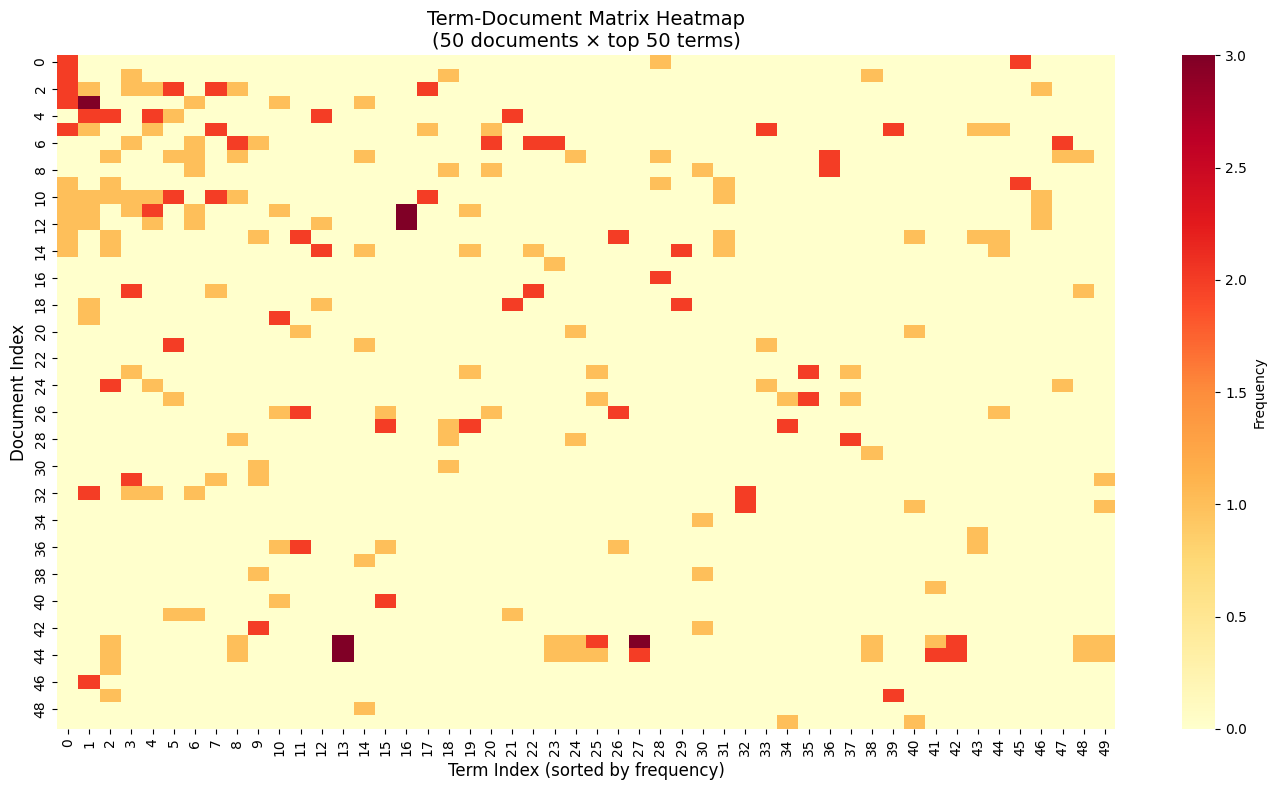

Density: 0.118000
Max value: 3

Top-10:
  1. reuters              (freq: 16)
  2. oil                  (freq: 16)
  3. new                  (freq: 13)
  4. market               (freq: 11)
  5. price                (freq: 10)
  6. economy              (freq: 10)
  7. say                  (freq: 8)
  8. stock                (freq: 8)
  9. week                 (freq: 8)
  10. company              (freq: 7)


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

nonzero_docs = []
for i in range(td_matrix.shape[0]):
    if td_matrix[i].nnz > 0:
        nonzero_docs.append(i)
        if len(nonzero_docs) >= 50:
            break

print(f"nonzero_docs: {len(nonzero_docs)}")

if td_matrix.nnz > 0:
    for i in range(min(5, td_matrix.shape[0])):
        row_nnz = td_matrix[i].nnz
        if row_nnz > 0:
            row_data = td_matrix[i].toarray().flatten()
            nonzero_indices = row_data.nonzero()[0][:5]

if nonzero_docs:
    submatrix = td_matrix[nonzero_docs, :]
    
    term_counts = np.array(submatrix.sum(axis=0)).flatten()
    nonzero_terms = np.where(term_counts > 0)[0]
    
    top_terms_idx = nonzero_terms[np.argsort(-term_counts[nonzero_terms])[:50]]
    
    sample_matrix = submatrix[:, top_terms_idx].toarray()
    
    if sample_matrix.sum() > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(sample_matrix, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Frequency'}, 
                    cbar=True, vmin=0)
        ax.set_title(f'Term-Document Matrix Heatmap\n({len(nonzero_docs)} documents × top {len(top_terms_idx)} terms)', fontsize=14)
        ax.set_xlabel('Term Index (sorted by frequency)', fontsize=12)
        ax.set_ylabel('Document Index', fontsize=12)
        
        plt.tight_layout()
        output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"
        output_file = os.path.join(output_dir, 'term_document_matrix_heatmap.png')
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Density: {sample_matrix.mean():.6f}")
        print(f"Max value: {sample_matrix.max():.0f}")
        
        # Show some top terms
        reverse_index = {v: k for k, v in term_index_dict.items()}
        print(f"\nTop-10:")
        for i, term_idx in enumerate(top_terms_idx[:10]):
            term = reverse_index.get(term_idx, f"term_{term_idx}")
            freq = term_counts[term_idx]
            print(f"  {i+1}. {term:20} (freq: {freq:.0f})")
    else:
        print("ZEROS")
else:
    print("No docs")

In [58]:
import pickle
import json

output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"

vocab_file = os.path.join(output_dir, "term_frequencies.json")
with open(vocab_file, 'w', encoding='utf-8') as f:
    json.dump(term_freq_dict, f, ensure_ascii=False, indent=2)

from scipy import sparse
td_sparse = sparse.csr_matrix(td_matrix)
matrix_file = os.path.join(output_dir, "term_document_matrix.npz")
sparse.save_npz(matrix_file, td_sparse)

sparse_size = (td_matrix.data.nbytes + td_matrix.indices.nbytes + td_matrix.indptr.nbytes) / 1024**2
disk_size = os.path.getsize(matrix_file) / 1024

print(f" Размер: {disk_size:.2f}kb")
print(f" Размер в памяти (разреженная): {sparse_size:.2f}mb")
print(f" Коэффициент сжатия: {sparse_size * 1024 / disk_size:.2f}x")

term_index_file = os.path.join(output_dir, "term_index.json")
with open(term_index_file, 'w', encoding='utf-8') as f:
    json.dump(term_index_dict, f, ensure_ascii=False, indent=2)

 Размер: 5621.11kb
 Размер в памяти (разреженная): 22.72mb
 Коэффициент сжатия: 4.14x


In [59]:

def vectorize_text_onehot_matrix(text_lemmas, term_index):
    """
    3: Преобразование текста в единичную матрицу с последующим усреднением.
    Каждая строка - токен, каждый столбец - один токен словаря.
    """
    # Фильтруем только известные токены
    known_lemmas = [l for l in text_lemmas if l in term_index]
    
    if not known_lemmas:
        return np.zeros(len(term_index))
    
    matrix = np.zeros((len(known_lemmas), len(term_index)))
    for i, lemma in enumerate(known_lemmas):
        idx = term_index[lemma]
        matrix[i, idx] = 1
    
    return matrix.mean(axis=0)

Базовыей метод векторизации текста (one hot)

In [60]:
def load_test_documents(lab1_path):
    documents = []
    test_path = os.path.join(lab1_path, 'test')
    
    if not os.path.exists(test_path):
        print(f"{test_path} не найдена!")
        return documents
    
    for class_name in sorted(os.listdir(test_path)):
        class_path = os.path.join(test_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for file_name in sorted(os.listdir(class_path)):
            if file_name.endswith('.tsv'):
                doc_id = file_name.replace('.tsv', '')
                file_path = os.path.join(class_path, file_name)
                lemmas = load_lemmas_from_tsv(file_path)
                if lemmas:
                    documents.append((doc_id, lemmas))
    
    return documents

test_documents = load_test_documents(lab1_path)
print(f"{len(test_documents)}")

if test_documents:
    sample_doc_id, sample_lemmas = test_documents[0]
    
    vec_onehot = vectorize_text_onehot_matrix(sample_lemmas, term_index_dict)
    print(f"Размерность: {len(vec_onehot)}")
    print(f"Ненулевых элементов: {(vec_onehot > 0).sum()}")
    print(f"Сумма значений: {vec_onehot.sum():.4f}")
    print(f"Норма вектора: {np.linalg.norm(vec_onehot):.4f}")

7600
Размерность: 39319
Ненулевых элементов: 15
Сумма значений: 1.0000
Норма вектора: 0.2652


Word2Vec

In [61]:
vector_size = 100  # Размерность векторов
window = 5         # Размер окна контекста
min_count = 2      # Минимальная частота слова
workers = 4        # Количество потоков
sg = 1            # 1 = skip-gram, 0 = CBOW
epochs = 10       # Количество эпох обучения

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    epochs=epochs
)

print(f"  Размер словаря: {len(w2v_model.wv)} слов")
print(f"  Размер векторов: {w2v_model.vector_size}")
print(f"  Архитектура: {'Skip-gram' if sg == 1 else 'CBOW'}")
print(f"  Размер окна: {window}")
print(f"  Эпох обучения: {epochs}")

model_file = os.path.join(output_dir, "word2vec.model")
w2v_model.save(model_file)

sample_words = list(w2v_model.wv.index_to_key)[:10]
for word in sample_words:
    vec = w2v_model.wv[word]
    print(f"  {word:15} - вектор размерности {len(vec)}, норма: {np.linalg.norm(vec):.4f}")

  Размер словаря: 41438 слов
  Размер векторов: 100
  Архитектура: Skip-gram
  Размер окна: 5
  Эпох обучения: 10
  39              - вектор размерности 100, норма: 2.2464
  say             - вектор размерности 100, норма: 2.6513
  new             - вектор размерности 100, норма: 2.3891
  reuters         - вектор размерности 100, норма: 3.0424
  ap              - вектор размерности 100, норма: 3.0730
  year            - вектор размерности 100, норма: 2.6632
  gt              - вектор размерности 100, норма: 4.0188
  lt              - вектор размерности 100, норма: 3.6685
  u               - вектор размерности 100, норма: 2.9692
  two             - вектор размерности 100, норма: 2.7479


косинусное сходство

In [62]:
def cosine_similarity(vec1, vec2):
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def cosine_distance(vec1, vec2):
    return 1 - cosine_similarity(vec1, vec2)

seed_words = ['sport', 'game', 'team', 'play', 'news']

for seed_word in seed_words:
    if seed_word in w2v_model.wv:
        print({seed_word})
        
        try:
            similar = w2v_model.wv.most_similar(seed_word, topn=5)
            print(f"Похожие слова:")
            for word, sim in similar:
                dist = 1 - sim
                print(f"  {word:15} - cos dist: {dist:.4f}")
        except KeyError:
            print(f"{seed_word} not found in vocabulary")
    else:
        print(f"{seed_word} not found in vocabulary")

{'sport'}
Похожие слова:
  network         - cos: 0.1774
  cbc             - cos: 0.3169
  tx              - cos: 0.3867
  sportsnetwork   - cos: 0.3873
  karate          - cos: 0.3948
{'game'}
Похожие слова:
  play            - cos: 0.3530
  matchup         - cos: 0.3573
  match           - cos: 0.3842
  opener          - cos: 0.3854
  season          - cos: 0.3879
{'team'}
Похожие слова:
  season          - cos: 0.3566
  team's          - cos: 0.3613
  mckendree       - cos: 0.3926
  Four.           - cos: 0.3979
  teammate        - cos: 0.3994
{'play'}
Похожие слова:
  playing         - cos: 0.3260
  match           - cos: 0.3291
  benched         - cos: 0.3444
  Cups.           - cos: 0.3460
  opener          - cos: 0.3506
{'news'}
Похожие слова:
  saba            - cos: 0.3407
  sana            - cos: 0.3431
  wam             - cos: 0.3463
  mena            - cos: 0.3505
  anatolian       - cos: 0.3510


In [63]:
def vectorize_document(lemmas, model):
    vectors = [model.wv[lemma] for lemma in lemmas if lemma in model.wv]
    
    if not vectors:
        return np.zeros(model.vector_size)
    
    doc_vector = np.mean(vectors, axis=0)
    
    return doc_vector

print(f"Размер векторов: {w2v_model.vector_size}")

Функция векторизации определена.
Размер векторов: 100


векторизация

In [64]:
def vectorize_document(lemmas, model):
    vectors = [model.wv[lemma] for lemma in lemmas if lemma in model.wv]
    
    if not vectors:
        return np.zeros(model.vector_size)
    
    doc_vector = np.mean(vectors, axis=0)
    
    return doc_vector

embeddings = []
doc_ids = []

for doc_id, lemmas in tqdm(test_documents, total=len(test_documents)):
    embedding = vectorize_document(lemmas, w2v_model)
    embeddings.append(embedding)
    doc_ids.append(doc_id)

print(f"\nВекторизовано {len(embeddings)} документов")
print(f"Размер вектора: {embeddings[0].shape}")

Векторизация тестовой выборки...


100%|██████████| 7600/7600 [00:00<00:00, 29905.60it/s]


Векторизовано 7600 документов
Размер каждого вектора: (100,)


In [65]:

output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "test_embeddings.tsv")

print(f"Сохранение результатов в {output_file}...")

with open(output_file, 'w', encoding='utf-8') as f:
    for doc_id, embedding in zip(doc_ids, embeddings):
        embedding_str = '\t'.join([f"{val:.6f}" for val in embedding])
        f.write(f"{doc_id}\t{embedding_str}\n")

Сохранение результатов в C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2\test_embeddings.tsv...
✓ Результаты сохранены в C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2\test_embeddings.tsv

Первые 3 строки файла:
Doc ID: 000000, Vector components: 100
  First 5 components: ['-0.043389', '0.184235', '-0.058497', '0.112688', '0.124865']
Doc ID: 000041, Vector components: 100
  First 5 components: ['0.023608', '0.113064', '0.029484', '-0.015504', '0.062809']
Doc ID: 000054, Vector components: 100
  First 5 components: ['-0.053267', '-0.157454', '-0.223443', '-0.218351', '0.121591']


Стата

In [66]:
embeddings_array = np.array(embeddings)

print("Статистика векторных представлений:")
print(f"Форма матрицы: {embeddings_array.shape}")
print(f"Среднее значение компонент вектора: {np.mean(embeddings_array):.6f}")
print(f"Стандартное отклонение: {np.std(embeddings_array):.6f}")
print(f"Минимальное значение: {np.min(embeddings_array):.6f}")
print(f"Максимальное значение: {np.max(embeddings_array):.6f}")

vector_norms = np.linalg.norm(embeddings_array, axis=1)
print(f"\nСтатистика норм векторов:")
print(f"Средняя норма: {np.mean(vector_norms):.6f}")
print(f"Минимальная норма: {np.min(vector_norms):.6f}")
print(f"Максимальная норма: {np.max(vector_norms):.6f}")

Статистика векторных представлений:
Форма матрицы: (7600, 100)
Среднее значение компонент вектора: 0.004430
Стандартное отклонение: 0.210056
Минимальное значение: -1.169196
Максимальное значение: 1.082396

Статистика норм векторов:
Средняя норма: 2.088849
Минимальная норма: 1.559815
Максимальная норма: 3.377618


In [67]:

sample_indices = [0, 1, 10, 20, 50] if len(embeddings_array) > 50 else list(range(min(5, len(embeddings_array))))

for i in range(len(sample_indices)-1):
    idx1 = sample_indices[i]
    idx2 = sample_indices[i+1]
    
    vec1 = embeddings_array[idx1]
    vec2 = embeddings_array[idx2]
    
    distance = cosine_distance(vec1, vec2)
    similarity = cosine_similarity(vec1, vec2)
    
    print(f"\nДокументы {doc_ids[idx1]} и {doc_ids[idx2]}:")
    print(f"  Косинусное расстояние: {distance:.6f}")
    print(f"  Косинусное сходство: {similarity:.6f}")

Анализ сходства документов (косинусное расстояние):

Документы 000000 и 000041:
  Косинусное расстояние: 0.281626
  Косинусное сходство: 0.718374

Документы 000041 и 000097:
  Косинусное расстояние: 0.320372
  Косинусное сходство: 0.679628

Документы 000097 и 000165:
  Косинусное расстояние: 0.284357
  Косинусное сходство: 0.715643

Документы 000165 и 000299:
  Косинусное расстояние: 0.314480
  Косинусное сходство: 0.685520


PCA

In [68]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [70]:
from sklearn.decomposition import PCA

print("Применение PCA для сокращения размерности базовых методов...")
print(f"Целевая размерность: {w2v_model.vector_size} (как у Word2Vec)")
print()

# Метод one-hot усреднение
vectors_onehot = []
for doc_id, lemmas in tqdm(test_documents, desc="Метод one-hot усреднение", total=len(test_documents)):
    vec = vectorize_text_onehot_matrix(lemmas, term_index_dict)
    vectors_onehot.append(vec)
vectors_onehot = np.array(vectors_onehot)

print(f"  Размерность до PCA: {vectors_onehot.shape[1]}")
print(f"  Количество документов: {vectors_onehot.shape[0]}")

target_dim = w2v_model.vector_size
print(f"\nПрименение PCA для сокращения до {target_dim} компонент...")

# PCA для метода one-hot
pca_onehot = PCA(n_components=target_dim, random_state=42)
vectors_onehot_pca = pca_onehot.fit_transform(vectors_onehot)
print(f"\n✓ Метод one-hot усреднение + PCA:")
print(f"  Размерность после PCA: {vectors_onehot_pca.shape[1]}")
print(f"  Объясненная дисперсия: {pca_onehot.explained_variance_ratio_.sum():.4f}")
print(f"  Первые 5 компонент объясняют: {pca_onehot.explained_variance_ratio_[:5].sum():.4f}")

# Сохранение результатов
np.save(os.path.join(output_dir, "vectors_onehot_pca.npy"), vectors_onehot_pca)
print(f"\n✓ Векторы с уменьшенной размерностью сохранены")

Применение PCA для сокращения размерности базовых методов...
Целевая размерность: 100 (как у Word2Vec)



Метод one-hot усреднение: 100%|██████████| 7600/7600 [00:09<00:00, 825.91it/s]


  Размерность до PCA: 39319
  Количество документов: 7600

Применение PCA для сокращения до 100 компонент...

✓ Метод one-hot усреднение + PCA:
  Размерность после PCA: 100
  Объясненная дисперсия: 0.2445
  Первые 5 компонент объясняют: 0.0462

✓ Векторы с уменьшенной размерностью сохранены


сравнение

  Word2Vec:           (7600, 100)
  One-hot + PCA:      (7600, 100)

Word2Vec:
  Среднее сходство: 0.6082
  Стд. отклонение:  0.0740
  Мин/макс:         0.3799 / 0.7778
  Медиана:          0.6128

One-hot + PCA:
  Среднее сходство: -0.0087
  Стд. отклонение:  0.1194
  Мин/макс:         -0.2200 / 0.4604
  Медиана:          -0.0417


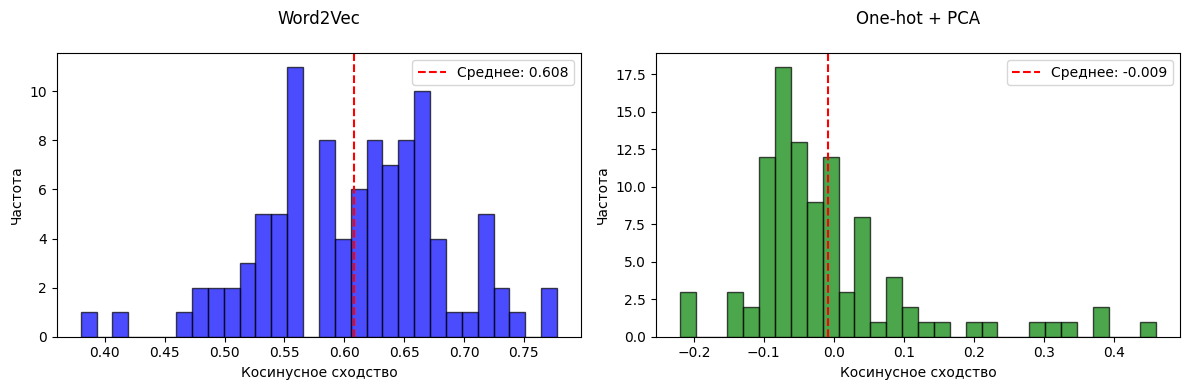

In [73]:

vectors_w2v = np.array(embeddings)

print(f"  Word2Vec:           {vectors_w2v.shape}")
print(f"  One-hot + PCA:      {vectors_onehot_pca.shape}")

def evaluate_vectors(vectors, method_name, num_pairs=100):
    np.random.seed(42)
    similarities = []
    
    for _ in range(num_pairs):
        idx1, idx2 = np.random.choice(len(vectors), 2, replace=False)
        sim = cosine_similarity(vectors[idx1], vectors[idx2])
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    print(f"\n{method_name}:")
    print(f"  Среднее сходство: {similarities.mean():.4f}")
    print(f"  Стд. отклонение:  {similarities.std():.4f}")
    print(f"  Мин/макс:         {similarities.min():.4f} / {similarities.max():.4f}")
    print(f"  Медиана:          {np.median(similarities):.4f}")
    
    return similarities

sim_w2v = evaluate_vectors(vectors_w2v, "Word2Vec")
sim_onehot_pca = evaluate_vectors(vectors_onehot_pca, "One-hot + PCA")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sim_w2v, bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[0].set_title('Word2Vec\n')
axes[0].set_xlabel('Косинусное сходство')
axes[0].set_ylabel('Частота')
axes[0].axvline(sim_w2v.mean(), color='red', linestyle='--', label=f'Среднее: {sim_w2v.mean():.3f}')
axes[0].legend()

axes[1].hist(sim_onehot_pca, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1].set_title('One-hot + PCA\n')
axes[1].set_xlabel('Косинусное сходство')
axes[1].set_ylabel('Частота')
axes[1].axvline(sim_onehot_pca.mean(), color='red', linestyle='--', label=f'Среднее: {sim_onehot_pca.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'method_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()